In [1]:
#pip install kaggle

# Get data

In [64]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import pandas as pd

data = pd.read_csv('fer2013.csv')
data.shape

(35887, 3)

In [3]:
data.head(2)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training


# Data processing

In [4]:
# number of training data point available for each label

data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [5]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## split rows

In [6]:
len(data.loc[0, 'pixels'].split())

2304

In [7]:
def transform(string_list=[]):
    return [int(p) for p in string_list]

In [8]:
data['pixels']  = data['pixels'].apply( lambda row: transform(row.split()) )

In [9]:
data.head(2)

,emotion,pixels,Usage
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",Training
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",Training


In [10]:
X = []

for i in range(35887):
    X.append(np.asarray( data.loc[i, 'pixels'] ))
    
X = np.asarray(X)

X.shape    

(35887, 2304)

## set emotions in an array

In [11]:
y = data['emotion'] #num_class

X.shape, y.shape

((35887, 2304), (35887,))

In [12]:
num_class = len(set(y))   # or y.nunique()
num_class

7

In [13]:
balance = data['emotion'].value_counts().sort_index()

balance

0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: emotion, dtype: int64

## Preparing X for Keras : reshape X

👉 Reshape X

In [14]:
# keras with tensorflow backend
N, D = X.shape # D = 2304
X = X.reshape(N, 48, 48, 1)  # np.sqrt(D) = 48
                             # the new-axis for number of channels (Keras)

In [85]:
y[:6]

0    0
1    0
2    2
3    4
4    6
5    2
Name: emotion, dtype: int64

## Display some images

In [86]:
# do not forget
#label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [97]:
np.where(y == 1)[0][:5]

array([299, 388, 416, 473, 533])

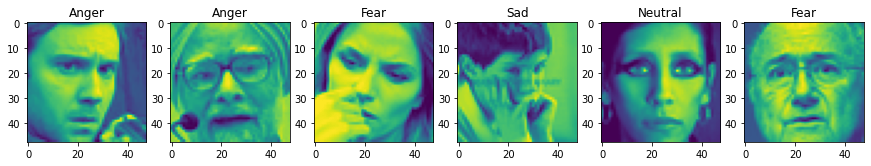

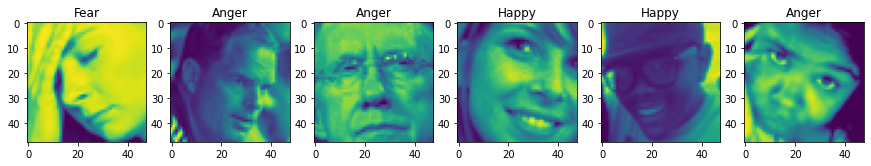

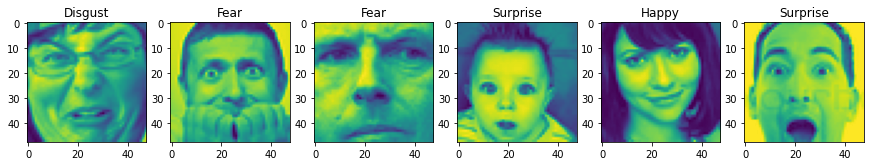

In [100]:
# Let's plot few images to see what they look like
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i in range(6):
    plt.subplot(1,6, i+1)
    img = X[i]
    plt.imshow(img);
    plt.title(label_map[y[i]]);
    
plt.figure(figsize=(15,5))
for i in range(121, 127):
    plt.subplot(2,6, i - 121 +1)
    img = X[i]
    plt.imshow(img);
    plt.title(label_map[y[i]]);    
    
plt.figure(figsize=(15,5))
for i in range(299, 305):
    plt.subplot(2,6, i - 299 +1)
    img = X[i]
    plt.imshow(img);
    plt.title(label_map[y[i]]);

## Preparing X for Keras : train_test_split X

In [16]:
# Split in  training set : validation set :  testing set in 80:10:10
from sklearn.model_selection import train_test_split

Xtrain, Xtest, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

Xtrain.shape, Xtest.shape

((32298, 48, 48, 1), (3589, 48, 48, 1))

In [17]:
Xtrain.shape, Xtest.shape, y_train.shape, y_test.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298,), (3589,))

👉 And, as usual,
- we normalize the data between 0 and 1
- we create `y` as one-hot-encoded version of `labels`

## Preparing X for Keras : normalize X /and/ one-hot-encode labels (y)

In [18]:
y_train[0]

0

In [20]:
#label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
labels = list(np.arange(num_class))

X_train = Xtrain / 255.  # .astype(np.float32)
X_test = Xtest / 255.

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [22]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Define CNN model

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import model_from_json

from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

#Main CNN model with four Convolution layer & two fully connected layer
def baseline_model():
    # Initialising the CNN
    model = Sequential()

    ### First convolution & max-pooling
    model.add(layers.Conv2D(16, kernel_size=(2,2),padding='same', input_shape=X_train.shape[1:])) #(48, 48, 1)
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))
        
    ### Second convolution & max-pooling
    model.add(layers.Conv2D(32, kernel_size=(3,3),padding='same', activation='relu')) # kernel_size = 3 <==> (3, 3)
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))

    ### Third convolution & max-pooling
    model.add(layers.Conv2D(32, kernel_size=(3,3),padding='same', activation='relu')) # kernel_size = 3 <==> (3, 3)
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    ### Fourth convolution & max-pooling
    model.add(layers.Conv2D(32, kernel_size=(2,2),padding='same', activation='relu')) # kernel_size = 2
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    ### Flattening
    model.add(layers.Flatten())
    ### One fully connected
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(num_class, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [57]:
# define model
model_base = baseline_model()


model_base.summary()



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 48, 48, 16)        80        
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 32)       

In [75]:

# fit model
history_base  = model_base.fit(X_train, y_train,
                                        validation_split=0.3,
                                       epochs=11, batch_size=32) #on colab epoch =100, batch_size=64
#es = EarlyStopping(patience=5, verbose=2)



Epoch 1/11
707/707 [==============================] - 33s 47ms/step - loss: 1.4320 - accuracy: 0.4460 - val_loss: 1.3313 - val_accuracy: 0.4873
Epoch 2/11
707/707 [==============================] - 35s 49ms/step - loss: 1.4217 - accuracy: 0.4537 - val_loss: 1.3311 - val_accuracy: 0.4933
Epoch 3/11
707/707 [==============================] - 37s 53ms/step - loss: 1.4099 - accuracy: 0.4571 - val_loss: 1.2977 - val_accuracy: 0.4915
Epoch 4/11
707/707 [==============================] - 40s 56ms/step - loss: 1.4007 - accuracy: 0.4593 - val_loss: 1.3108 - val_accuracy: 0.4883
Epoch 5/11
707/707 [==============================] - 39s 55ms/step - loss: 1.3831 - accuracy: 0.4661 - val_loss: 1.3039 - val_accuracy: 0.4915
Epoch 6/11
707/707 [==============================] - 39s 55ms/step - loss: 1.3791 - accuracy: 0.4699 - val_loss: 1.2715 - val_accuracy: 0.5047
Epoch 7/11
707/707 [==============================] - 41s 57ms/step - loss: 1.3756 - accuracy: 0.4721 - val_loss: 1.2933 - val_accuracy:

In [76]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

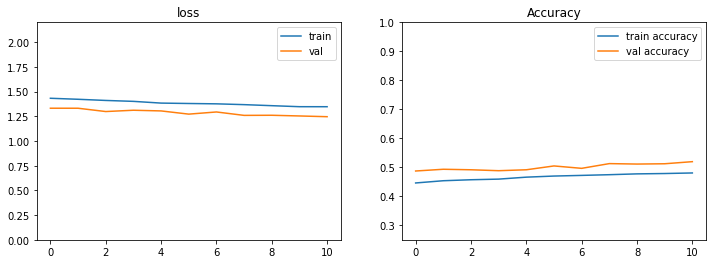

In [77]:
plot_history(history_base);

In [78]:
accuracy_baseline = 1/7 # there are 7 categ
accuracy_baseline

0.14285714285714285

## Evaluate model

In [79]:
# evaluate model
res = model_base.evaluate(X_test, y_test, verbose=0)
res

[1.243011236190796, 0.5165784358978271]

In [80]:
print(f'The accuracy on the test set is of {res[1]*100:.2f} %')
print(f'The baseline accuracy is of {accuracy_baseline*100} %')

The accuracy on the test set is of 51.66 %
The baseline accuracy is of 14.285714285714285 %


## Save model

In [81]:
# save model
model_base.save('model_4layer_2_2_pool_Dropout.h5')

# Make predictions

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

The class number, based on test data :  4
The corresponding label face : Sad


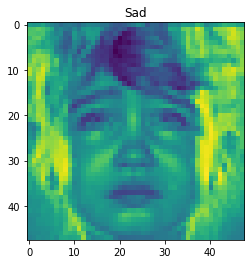

In [117]:
#Make Prediction
# Let's take a image from the test data to make predictions 

img = X_test[388]
plt.imshow(img)
display(y_test[388,:])
w = np.where( y_test[388,:] == 1 )[0][0] # #label_map = ['Anger', 'Disgust', 'Fear', 
                                    #             'Happy', 'Sad', 'Surprise', 'Neutral']
print('The class number, based on test data : ', w)
print('The corresponding label face :', label_map[w])
plt.title(label_map[w]);

In [112]:
img.shape

(48, 48, 1)

In [113]:
# reshape into a single sample with 1 channels
new_img = img.reshape(1, 48, 48, 1)

In [118]:
# predict the class
result = model_base.predict_classes(new_img)
result

print('The predicted class number : ', result[0])
print('The corresponding label face :', label_map[result[0]])

The predicted class number :  4
The corresponding label face : Sad


# Optional 

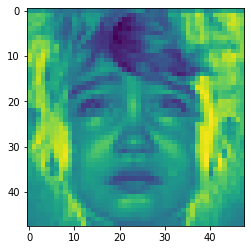

In [132]:
# the images are with one channel/color
    
plt.imshow(img);

In [148]:
from skimage.color import rgb2hsv, hsv2rgb
from skimage.io import imshow, imread

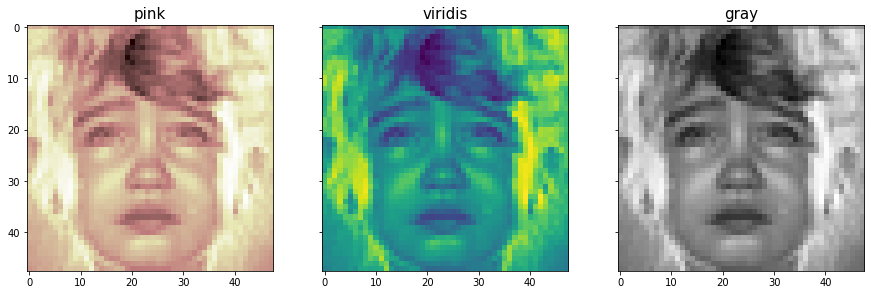

In [168]:
def rgb_splitter(image):
    rgb_list = ['pink','viridis','gray']
    fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey = True)
    for i in range(3):
        ax[i].imshow(image, cmap = rgb_list[i])
        ax[i].set_title(rgb_list[i], fontsize = 15)

rgb_splitter(img)


In [169]:
#plt.colormaps()